In [ ]:
# !git clone https://github.com/alx87grd/minilink
# import sys
# sys.path.append('/content/minilink')

Cloning into 'minilink'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 150 (delta 89), reused 100 (delta 51), pack-reused 0 (from 0)
Receiving objects: 100% (150/150), 55.25 KiB | 775.00 KiB/s, done.
Resolving deltas: 100% (89/89), done.


In [15]:
from framework import DynamicSystem, StaticSystem
from sources import Step, WhiteNoise
from diagram import DiagramSystem
import numpy as np

In [ ]:
from minilink_tests import Pendulum, PDController, Integrator, PropController
# import matplotlib
# matplotlib.use('Inline')

# Diagram Creation

## Subsystem definitions

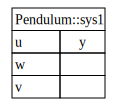

In [17]:
# Plant system
sys = Pendulum()
sys.params['m'] = 1.0
sys.params['l'] = 5.0
sys.x0[0] = 2.0

sys

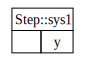

In [18]:
# Source input
step = Step()
step.params['initial_value'] = np.array([0.0])
step.params['final_value'] = np.array([1.0])
step.params['step_time'] = 10.0

step

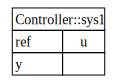

In [19]:
# Closed loop system
ctl = PDController()
ctl.params['Kp'] = 1000.0
ctl.params['Kd'] = 100.0
ctl

## Creating the diagram

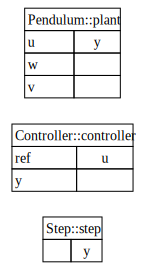

In [20]:
# Diagram
diagram = DiagramSystem()

diagram.add_subsystem(step,"step")
diagram.add_subsystem(ctl,'controller')
diagram.add_subsystem(sys,'plant')

diagram

In [21]:
diagram.compute_trajectory( show=True)

Simulator:
--------------
Simulating system Diagram from t=0 to t=10
Automatic dt based on the smallest time constant of the system
Time steps = 100001, dt=0.0001 and solver= scipy


Connected step:y to controller:ref


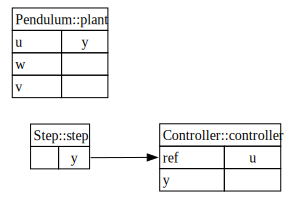

In [22]:
diagram.connect('step','y','controller','ref')
diagram

Connected controller:u to plant:u


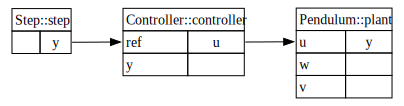

In [23]:
diagram.connect('controller','u','plant','u')
diagram

In [24]:
diagram.compute_trajectory()

Simulator:
--------------
Simulating system Diagram from t=0 to t=10
Automatic dt based on the smallest time constant of the system
Time steps = 100001, dt=0.0001 and solver= scipy


Connected plant:y to controller:y


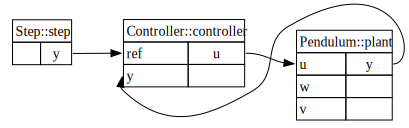

In [25]:
diagram.connect('plant','y','controller','y')
diagram

In [26]:
diagram.compute_trajectory()

Simulator:
--------------
Simulating system Diagram from t=0 to t=10
Automatic dt based on the smallest time constant of the system
Time steps = 100001, dt=0.0001 and solver= scipy


# Custom sys

In [27]:
class Integrator(DynamicSystem):

    def __init__(self):

        super().__init__(1, 1, 1)
        self.name = "Integrator"
        self.outputs = {}
        self.add_output_port(1, "y", function=self.h, dependencies=[])

    def f(self, x, u, t=0, params=None):

        dx = np.zeros(self.n)
        dx[0] = u[0]

        return dx

    def h(self, x, u, t=0, params=None):

        y = np.zeros(self.p)
        y[0] = x[0]

        return y

In [28]:
class PropController(StaticSystem):
    def __init__(self):
        super().__init__(2, 1)

        self.params = {
            "Kp": 10.0,
        }

        self.name = "Controller"

        self.inputs = {}
        self.add_input_port(1, "ref", nominal_value=np.array([0.0]))
        self.add_input_port(1, "y", nominal_value=np.array([0.0]))

        self.outputs = {}
        self.add_output_port(1, "u", function=self.ctl, dependencies=["ref", "y"])

    ######################################################################
    def ctl(self, x, u, t=0, params=None):

        if params is None:
            params = self.params

        Kp = params["Kp"]

        r = u[0]
        y = u[1]

        u = Kp * (r - y)

        u = np.array([u])

        return u

Connected integrator1:y to integrator2:u
Connected controller2:u to integrator1:u
Connected integrator1:y to controller2:y
Connected controller1:u to controller2:ref
Connected integrator2:y to controller1:y
Connected step:y to controller1:ref


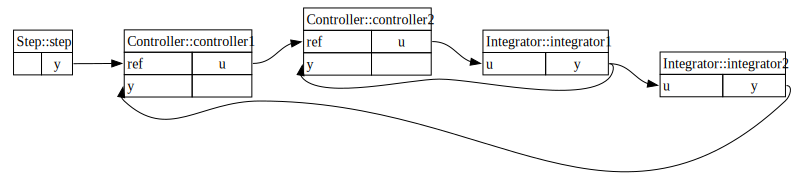

In [33]:
## Cascade controller diagram

# Plant system
sys1 = Integrator()
sys1.state.labels = ["v"]
sys1.x0[0] = 20.0
sys2 = Integrator()
sys2.state.labels = ["x"]
sys2.x0[0] = 20.0

# Controllers
ctl1 = PropController()
ctl1.params["Kp"] = 1.0
ctl2 = PropController()
ctl2.params["Kp"] = 1.0

# Source input
step = Step()
step.params["initial_value"] = np.array([0.0])
step.params["final_value"] = np.array([1.0])
step.params["step_time"] = 10.0

# # Diagram
diagram = DiagramSystem()

diagram.add_subsystem(step, "step")
diagram.add_subsystem(ctl1, "controller1")
diagram.add_subsystem(ctl2, "controller2")
diagram.add_subsystem(sys1, "integrator1")
diagram.add_subsystem(sys2, "integrator2")

diagram.connect("integrator1", "y", "integrator2", "u")
diagram.connect("controller2", "u", "integrator1", "u")
diagram.connect("integrator1", "y", "controller2", "y")
diagram.connect("controller1", "u", "controller2", "ref")
diagram.connect("integrator2", "y", "controller1", "y")
diagram.connect("step", "y", "controller1", "ref")
diagram

In [34]:
diagram.compute_trajectory()

Simulator:
--------------
Simulating system Diagram from t=0 to t=10
Automatic dt based on the smallest time constant of the system
Time steps = 100001, dt=0.0001 and solver= scipy
